In [1]:
"""Generate 1000 Gaussian mocks based on based on $C_l$s from CCL."""

'Generate 1000 Gaussian mocks based on based on $C_l$s from CCL.'

In [2]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import pyccl as ccl

from tqdm import tqdm #for timing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

from IPython.display import HTML
from IPython.display import display

sys.path.insert(1, '../src/')

/home/tanveer/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1: Generate $C^{gg}_{L}$ from `CCL`

In [3]:
#params
fs = 20
fsize = (10, 7)

NSIDE = 1024
lmin = 100; lmax = 3 * NSIDE - 1
ell = np.arange(0, lmax, 1)
Omega_c = 0.27
Omega_b = 0.045
h = 0.67
sigma8 = 0.83
n_s = 0.96

Text(0, 0.5, 'dn')

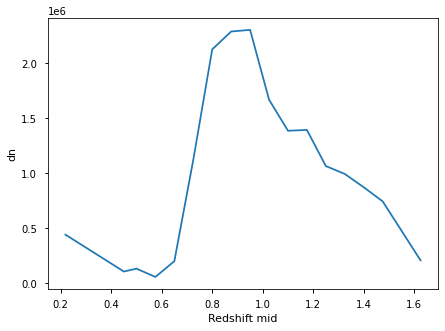

In [4]:
#define cosmology
cosmo = ccl.Cosmology(Omega_c = Omega_c, Omega_b = Omega_b, h = h, sigma8 = sigma8, n_s = n_s)

#read in dNdz
dNdzddeg2 = pd.read_csv("../dat/nz_blanc.txt", sep=",")
zmid = dNdzddeg2['Redshift_mid']
dndz = dNdzddeg2['dndz/deg^2'] * 14000
dn = dndz[:-1] * np.diff(zmid)  #redshift bin width

plt.figure(figsize=(7, 5))
plt.plot(zmid[:-1], dn)
plt.xlabel("Redshift mid")
plt.ylabel("dn")

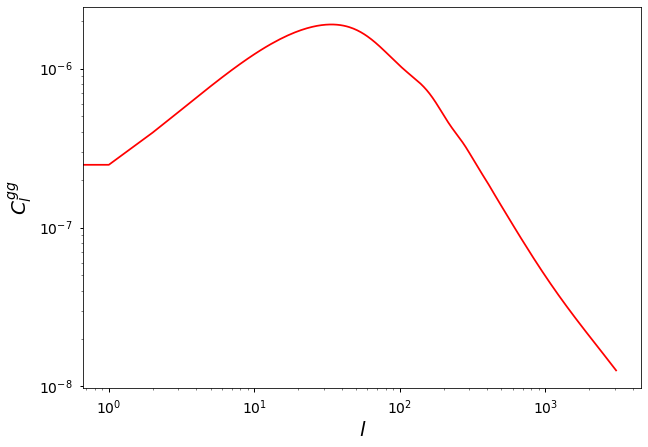

In [5]:
#set constant bias
b = 1.2*np.ones(len(zmid[:-1]))

#Create CCL tracer object for galaxy clustering
elg_ccl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zmid[:-1], dn), bias=(zmid[:-1],b))

#calculate theoretical Cls
cls_elg_th = ccl.angular_cl(cosmo, elg_ccl, elg_ccl, ell)

plt.figure(figsize = fsize)
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{g g}_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_elg_th, 'r-')

# 2: Generate a realization and noise map

## Realization

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

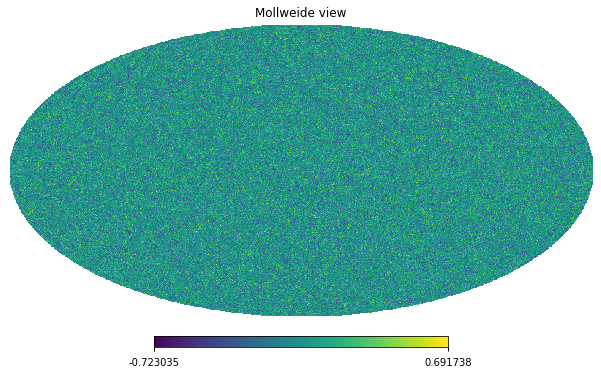

In [6]:
delta_g = hp.synfast(cls_elg_th, nside = NSIDE, pol=False, verbose=False)
hp.mollview(delta_g)

## Noise Map

Compare shot noise, $N_s$ with $C_l$

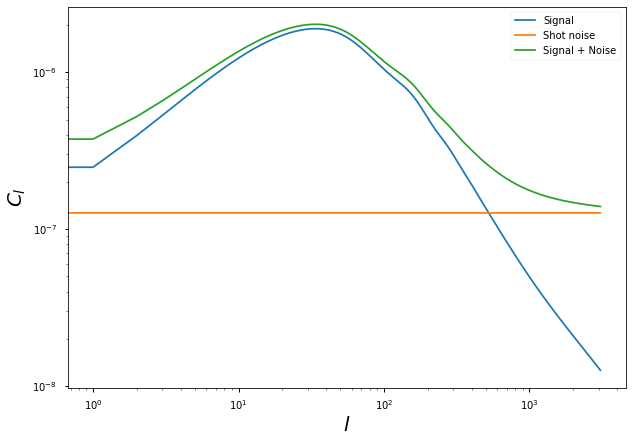

In [7]:
nbar_sqdeg = 2400 #per deg2
nbar_sr = (np.pi/180)**(-2) * nbar_sqdeg #conversion factor from sq deg to sr. 1 deg2 = 4pi^2/129600 sr
cl_shot_noise = 1/nbar_sr * np.ones_like(ell)

plt.figure(figsize = fsize)
plt.loglog(ell, cls_elg_th, label = 'Signal')
plt.loglog(ell, cl_shot_noise, label = 'Shot noise')
plt.loglog(ell, cls_elg_th + cl_shot_noise, label = 'Signal + Noise')
plt.xlabel("$l$", fontsize = fs)
plt.ylabel("$C_l$", fontsize = fs)
plt.legend(loc = 'best')
plt.show()

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

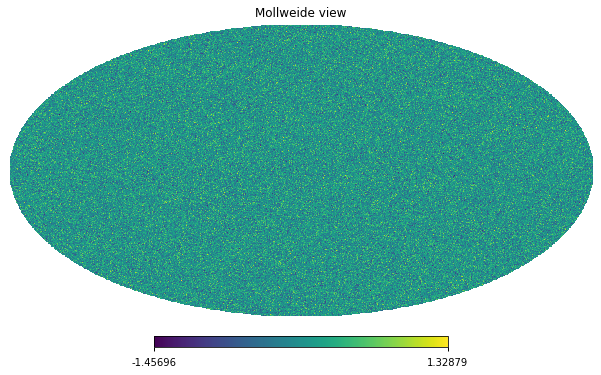

In [8]:
noise_g = hp.synfast(cl_shot_noise, nside = NSIDE, pol = False, verbose = False)
hp.mollview(noise_g)

# 3: Apply imaging systematics 

## Import Mehdi's neural network weight map

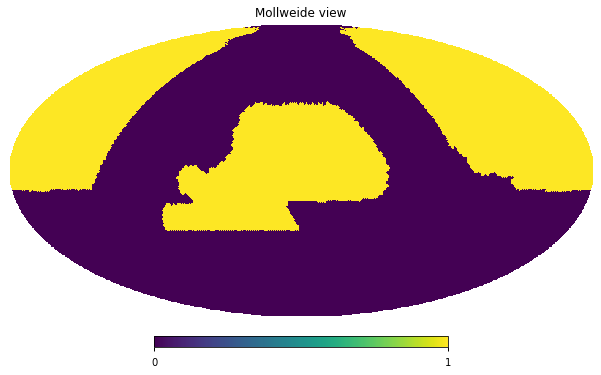

In [9]:
#read in random and degrade it to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
dr_elg_ran64 = hp.ud_grade(dr_elg_ran, 64) #make it very coarse to remove weird effects in the middle
dr_elg_ran_final = hp.ud_grade(dr_elg_ran64, NSIDE)

mask = np.copy(dr_elg_ran_final)
mask[dr_elg_ran_final != 0] = 1 #good pixels are 1
mask = mask.astype("bool")
hp.mollview(mask)

In [10]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)

from lib import GenSys

gs = GenSys('../dat/nn-weights-combined_1024.fits', nside = NSIDE)          # window functions

#--- contaminate a given density field
delta_c, F = gs.contaminate(gs.fetch_window(0), delta_g, mask, noisemap = noise_g)

# of selection functions:  (4805767, 100)


### Visualize truth and contaminated maps

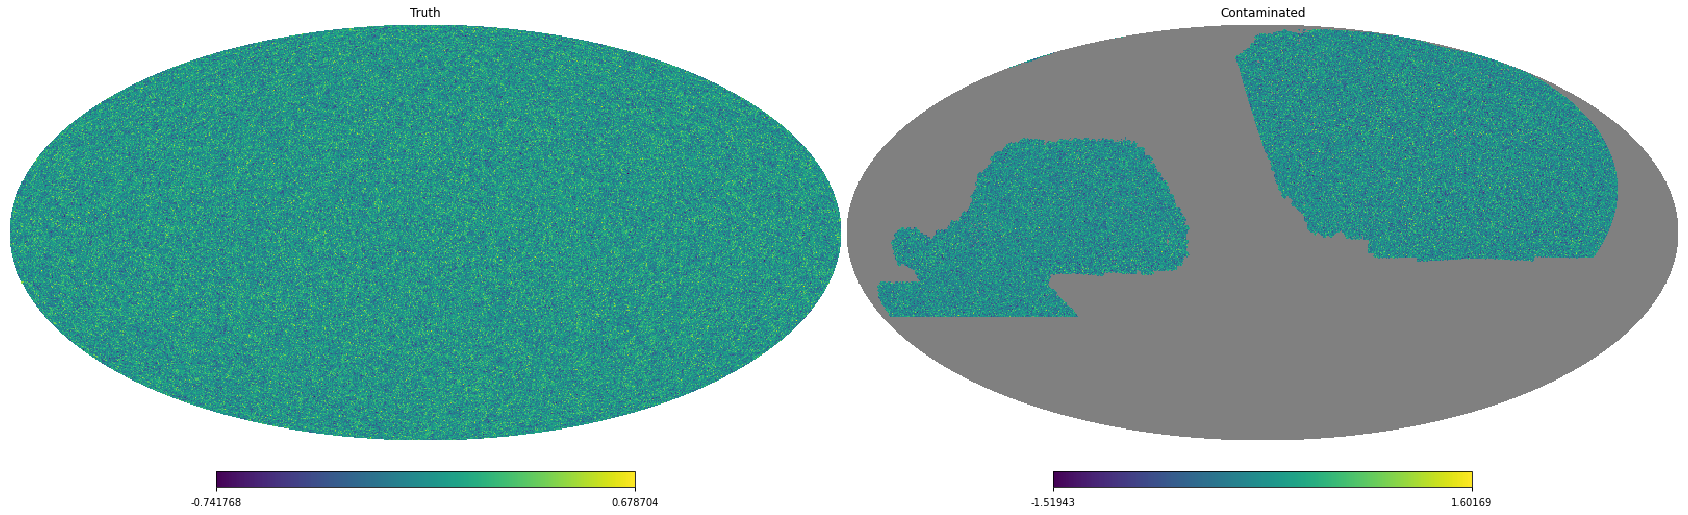

In [11]:
fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

for i, (map_i, title_i) in enumerate(zip([delta_g, delta_c],
                                         ['Truth', 'Contaminated'])):
    plt.sca(ax[i])
    hp.mollview(map_i, rot=-85, hold=True, title=title_i)

### Visualize selection function

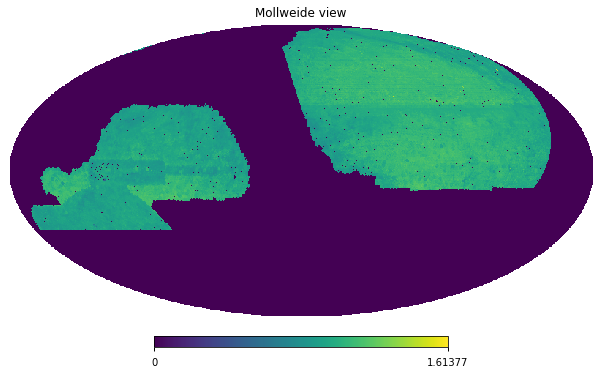

In [12]:
hp.mollview(F, rot = -85)

## Determine average selection function $<F>$

In [13]:
nselfunc = 100 #number of selection functions
Fmean = np.zeros(nselfunc) #store the mean of each selection function
Favg_map = np.zeros(12*NSIDE**2) #store the average selection function

for i in range(nselfunc):
    tmpF = gs.fetch_window(i) #tmp variable to store each call
    Fmean[i] = np.mean(tmpF[mask > 0])
    
    if(i == 0): #define running average
        Favg_map = tmpF
    else:
        Favg_map = (tmpF + i * Favg_map)/(i + 1) 

### Determine mean of selection functions

Ideally, $<F> \approx 1$.

Text(0.5, 0, '<F>')

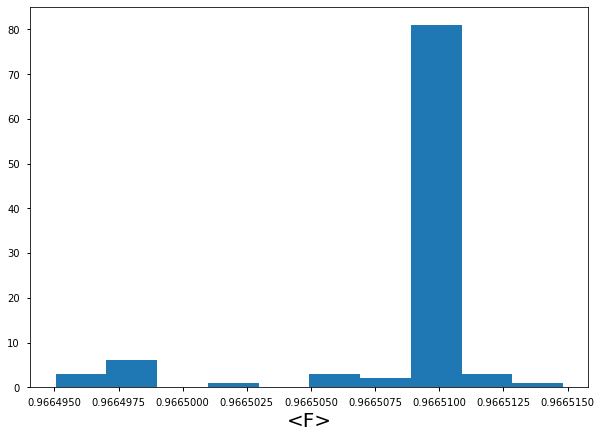

In [14]:
plt.figure(figsize = (10, 7))
plt.hist(Fmean)
plt.xlabel("<F>", fontsize = fs)

**Observation:** Selection function is not quite $1$. It is $\sim 0.9665$. 

Note from Mehdi: This is because we are clipping the extreme values in the systematics map because we do not expect such "unrealistic" values. Which is why the mean is a bit less than $1$.

Plan: Renormalize per map to $<F> = 1$. 

### Visualize average contaminated map

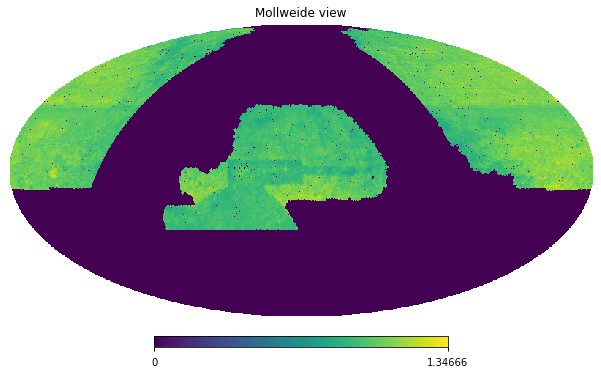

In [15]:
hp.mollview(Favg_map)

# 4: Experiments with different contaminated maps
Here, $F \equiv$ selection function, $\delta_g \equiv$ overdensity map and $N_{s} \equiv$ noise map.

For each experiment, we generate $100$ Gaussian mocks and calculate the covariance matrix.

- A: Fixed Window - $<F> \delta_g + \sqrt{<F>} N_{s}$
- B: Variable Window - $F\delta_g + \sqrt{F} N_{s}$
- C: Variable Window - $F (1 + \delta_g) + \sqrt{F} N_{s} - <F>$

## Experiment A: Fixed Window - $<F> \delta_g + \sqrt{<F>} N_{s}$

### Generate Gaussian mocks

In [16]:
NMOCKS = 100
delta_g = np.zeros((NMOCKS, 12 * NSIDE**2))

SEED = 67 #random seed
for i in tqdm(range(NMOCKS)):
    np.random.seed(SEED + i**2) #different seed for each mock
    delta_g[i] = hp.synfast(cls_elg_th, nside = NSIDE, pol=False, verbose=False)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


### Apply Selection Function, $F$, to mocks

In [17]:
delta_c_A = np.zeros((NMOCKS, 12 * NSIDE**2))

SEED = 10
for i in tqdm(range(NMOCKS)):
    np.random.seed(SEED + i**2)
    noise_g = hp.synfast(cl_shot_noise, nside = NSIDE, pol = False, verbose = False)
    
    delta_c_A[i], _ = gs.contaminate(Favg_map, delta_g[i], mask, noisemap = noise_g) #add img sys

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


### Visualize one contaminated map

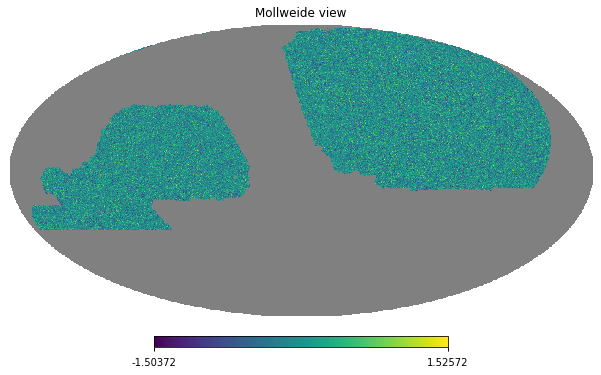

In [18]:
#view one map
hp.mollview(delta_c_A[50], rot=-85)

### Calculate $\tilde{C_{l}^{gg}}$ for all maps

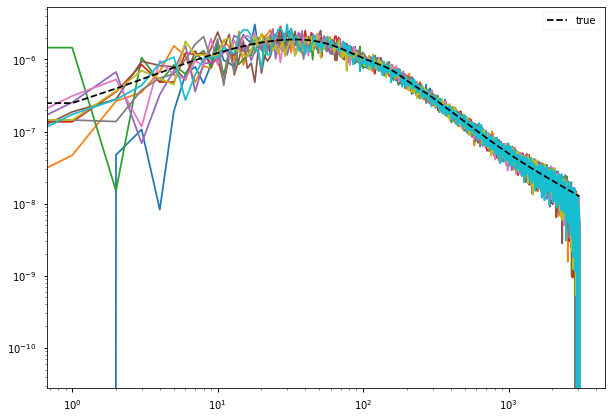

In [21]:
cls_obs_A = np.zeros((NMOCKS, lmax))

noise_window = np.mean(Favg_map)*1/nbar_sr

for i in range(NMOCKS):
    cls_obs_A[i] = hp.anafast(delta_c_A[i], lmax = lmax -1) - noise_window
    
fsky = np.sum(mask)/mask.shape[0] 

plt.figure(figsize = fsize)
for i in range(10):
    plt.loglog(ell, cls_obs_A[i]/fsky)
plt.loglog(ell, cls_elg_th, label = 'true', ls = '--', c = 'k')    
plt.legend(loc = 'best')

In [26]:
import itertools
def bin_mat(r=[],mat=[],r_bins=[]):
    """Sukhdeep's Code to bins data and covariance arrays

    Input:
    -----
        r  : array which will be used to bin data, e.g. ell values
        mat : array or matrix which will be binned, e.g. Cl values
        bins : array that defines the left edge of the bins,
               bins is the same unit as r

    Output:
    ------
        bin_center : array of mid-point of the bins, e.g. ELL values
        mat_int : binned array or matrix
    """

    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

In [32]:
ELL = np.logspace(0, 3, 10)
CLs_obs_A = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_A[i] = bin_mat(ell, cls_obs_A[i], ELL)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Calculate covariance matrix and visualize

<AxesSubplot:>

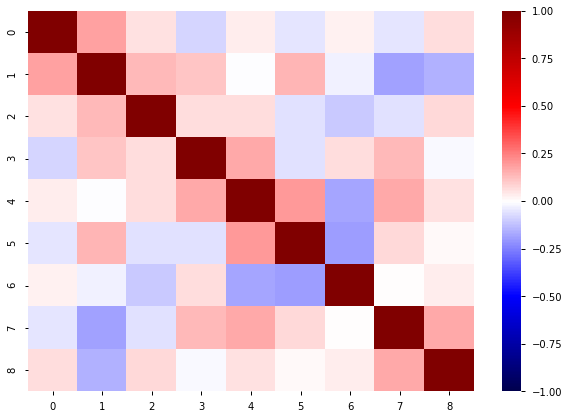

In [33]:
covmat_A = np.corrcoef(CLs_obs_A.T)

plt.figure(figsize = fsize)
sns.heatmap(covmat_A, cmap = 'seismic', vmin = -1, vmax = +1)

## B: Variable Window - $F\delta_g + \sqrt{F} N_{s}$

We use the same Gaussian realizations and noise realizations

In [ ]:
#Apply Selection function to mocks
delta_c_B = np.zeros((NMOCKS, 12 * NSIDE**2))

SEED = 10
for i in tqdm(range(NMOCKS)):
    delta_c_A[i], _ = gs.contaminate(Favg_map, delta_g[i], mask, noisemap = noise_g) #add img sys

## Same imaging systematics model with different realizations

## Varying systematics model with different realizations

In [34]:
delta_c = np.zeros((NMOCKS, 12 * NSIDE**2))

for i in tqdm(range(NMOCKS)):
    noise_g = hp.synfast(cl_shot_noise, nside = NSIDE, pol = False, verbose = False)
    delta_c[i] = gs.contaminate(i, delta_g[i], mask, noisemap = noise_g)

100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


In [37]:
cls_obs_vary = np.zeros((NMOCKS, lmax))

for i in tqdm(range(NMOCKS)):
    cls_obs_vary[i] = hp.anafast(delta_c[i], lmax = lmax -1)

100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


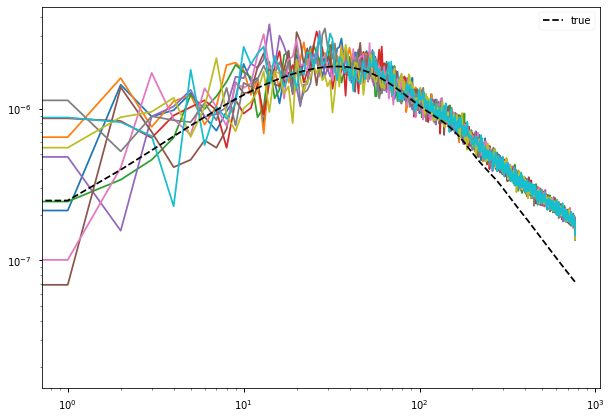

In [50]:
plt.figure(figsize=fsize)
#plt.loglog(ell, tmpcl, label = 'true', ls = '--', c = 'k')
for i in range(10):
    plt.loglog(ell, cls_obs_vary[i]/fsky)
plt.loglog(ell, cls_elg_th, label = 'true', ls = '--', c = 'k')
plt.legend(loc = 'best')

In [39]:
#calculate covariance matrix
covmat_vary = np.corrcoef(cls_obs_vary.T)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


(1, 767)

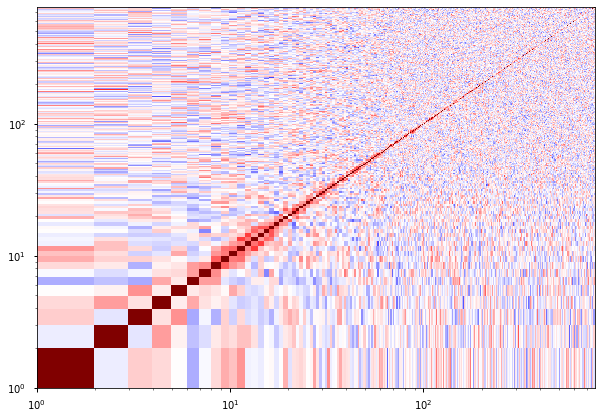

In [41]:
#visualize covariance matrix
plt.figure(figsize = fsize)
plt.pcolor(ell, ell, covmat_vary, cmap = 'seismic', vmin = -1, vmax = 1)
plt.loglog()
plt.xlim([1, lmax])
plt.ylim([1, lmax])

## Compare differences of the covariance matrices

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


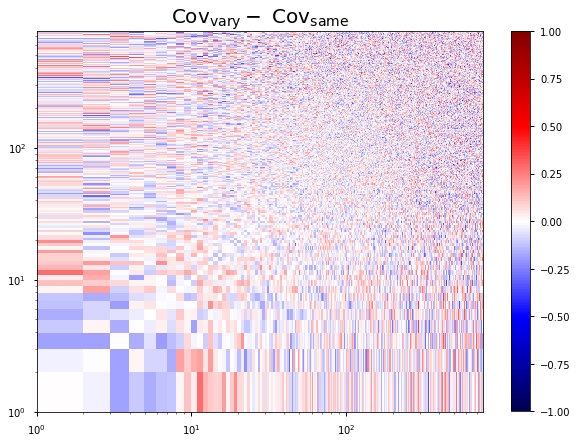

In [46]:
plt.figure(figsize = fsize)
plt.pcolor(ell, ell, covmat_vary - covmat_same, cmap = 'seismic', vmin = -1, vmax = 1)
plt.loglog()
plt.title(r"Cov$_{\rm vary} - $ Cov$_{\rm same}$", fontsize = fs)
plt.xlim([1, lmax])
plt.ylim([1, lmax])
plt.colorbar()

### True covariance

In [51]:
cls_obs_true = np.zeros((NMOCKS, lmax))

for i in tqdm(range(NMOCKS)):
    cls_obs_true[i] = hp.anafast(delta_g[i], lmax = lmax -1)

100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


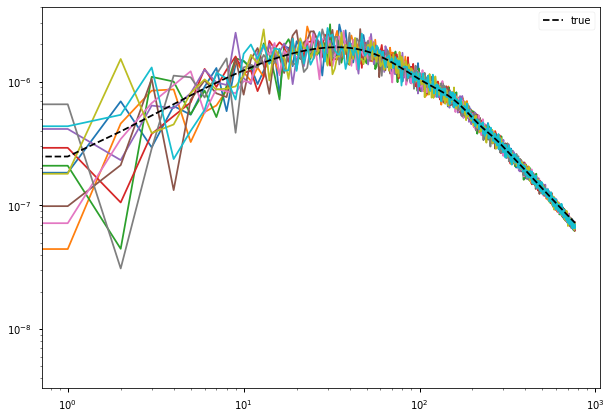

In [52]:
plt.figure(figsize=fsize)
#plt.loglog(ell, tmpcl, label = 'true', ls = '--', c = 'k')
for i in range(10):
    plt.loglog(ell, cls_obs_true[i])
plt.loglog(ell, cls_elg_th, label = 'true', ls = '--', c = 'k')
plt.legend(loc = 'best')

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(1, 767)

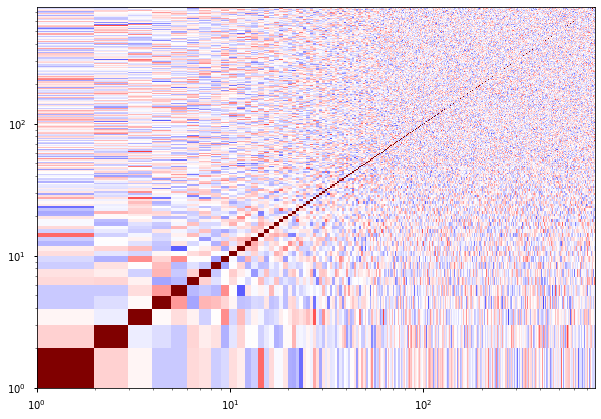

In [53]:
#calculate covariance matrix
covmat_allsky = np.corrcoef(cls_obs_true.T)

#visualize covariance matrix
plt.figure(figsize = fsize)
plt.pcolor(ell, ell, covmat_allsky, cmap = 'seismic', vmin = -1, vmax = 1)
plt.loglog()
plt.xlim([1, lmax])
plt.ylim([1, lmax])

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


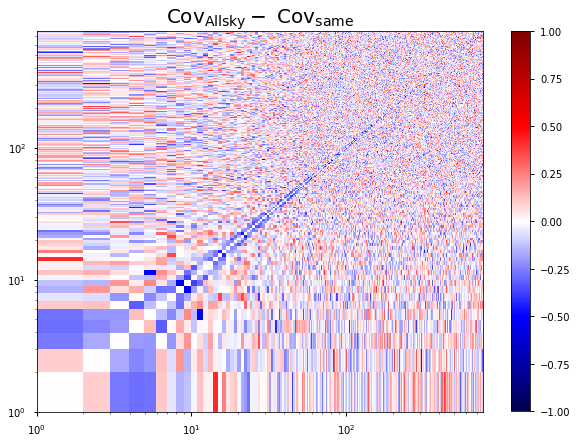

In [54]:
plt.figure(figsize = fsize)
plt.pcolor(ell, ell, covmat_allsky - covmat_same, cmap = 'seismic', vmin = -1, vmax = 1)
plt.loglog()
plt.title(r"Cov$_{\rm All sky} - $ Cov$_{\rm same}$", fontsize = fs)
plt.xlim([1, lmax])
plt.ylim([1, lmax])
plt.colorbar()

## Test with SFD EBV map

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

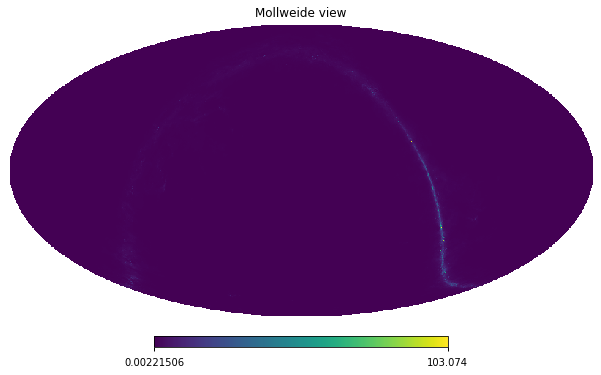

In [100]:
ebv = hp.read_map("../dat/healSFD_256_fullsky.fits", )

hp.mollview(ebv)

### Clean mock X EBV

In [101]:
cl_clean_ebv = hp.anafast(delta_g[0], ebv, lmax = lmax - 1)

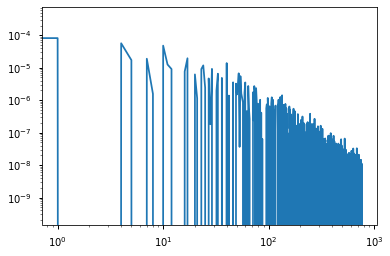

In [103]:
plt.loglog(ell, cl_clean_ebv)

### Contaminated mock X EBV

In [104]:
cl_contam_ebv = hp.anafast(delta_c[0], ebv, lmax = lmax - 1)

(-5.0, 10.0)

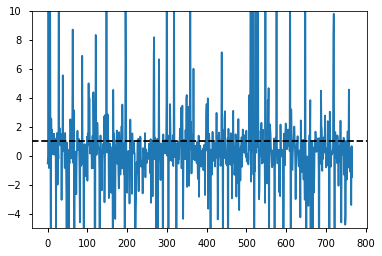

In [112]:
plt.plot(ell, cl_contam_ebv/cl_clean_ebv)
plt.axhline(1, c = 'k', ls = '--')
plt.ylim([-5, 10])

### Window X EBV

In [120]:
cl_win_ebv = hp.anafast(gs.fetch_window(0), ebv, lmax = lmax - 1)

(-5.0, 10.0)

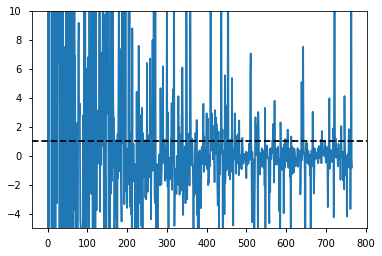

In [121]:
plt.plot(ell, cl_win_ebv/cl_clean_ebv)
plt.axhline(1, c = 'k', ls = '--')
plt.ylim([-5, 10])

In [ ]:
plt.figure(figsize = fsize)
plt.loglog(ell, cl_clean_ebv, alpha = 0.5, label = 'Clean X EBV')
plt.loglog(ell, cl_contam_ebv, alpha = 0.5, label = 'Contaminated X EBV')
plt.loglog(ell, cl_win_ebv, alpha = 0.5, label = 'Window X EBV')
plt.xlabel("l", fontsize = fs)
plt.ylabel(r"$C_{l}^{EBV \times \delta}$", fontsize = fs)
plt.legend(loc = 'best')